In [193]:
import numpy as np
import cmath
import math
from sklearn.preprocessing import normalize
from scipy.constants import epsilon_0 as ε_0, c, pi as π, e, hbar as ℏ
eV = e
from scipy.special import lpmn, sph_jn, sph_yn
from scipy.misc import factorial
from numpy import newaxis as nx

I = np.identity(3)

## Green's functions
All vectors are expected to be in cartesian coordinates. Arguments and return values are in form of arrays ("lists") to enable fast batch processing.
### Free space

In [23]:
# Transverse delta; invalit at r1 = r2
def δ_T(r1, r2):
    print("Not implemented")
    return

# Longitudinal delta; invalid at r1 = r2
def δ_L(r1, r2):
    print("Not implemented")
    return

def G_fs(r1, r2, ω):
    r12 = np.linalg.norm((r1-r2), axis=1)
    g = np.exp(1j * r12 * ω/c) / (4*π*r12)
    return np.outer(g, I)    

def K_fs(r1, r2, ω):
    print("Not implemented")
    return

### Spherical particle (Mie solution)
TODO

In [307]:
# r[:,0] = x = r sin θ cos φ
# r[:,1] = y = r sin θ sin φ
# r[:,2] = z = r cos θ
def spherical_vector_waves(nmax, k, r):
    # FIXME the implementation is _wrong_ very near z axis
    # and the problem remains in the derivatives of Legendre polynomials
    # k is single scalar, r is single 3D vector
    r.shape = (3) # FIXME do proper check
    ρ = np.linalg.norm(r)
    r̂ = r/ρ
    cosθ = r̂[2]
    sinθ = np.sqrt(1-cosθ*cosθ) # FIXME np->math
    cosφ = r̂[0]/sinθ if sinθ else 0 # avoid zero division here
    sinφ = r̂[1]/sinθ if sinθ else 1
    φ = np.arctan2(sinφ,cosφ)
    # TODO can those be views so I don't have to write the indices
    # explicitly?
    m = np.arange(nmax+1)
    n = m
    sinmφ = np.sin(m*φ)
    cosmφ = np.cos(m*φ)
    θ̂ = np.array([cosθ*cosφ,cosθ*sinφ,-sinθ])
    φ̂ = np.array([-sinφ, cosφ, 0])
    jnkr2 = sph_jn(nmax, k*ρ)
    # scipy.special.lpmn is for real arguments (see also clpmn)
    # + derivatives
    # m's are non-negative, cf. Bohren&Huffman (4.23)
    Pmn2 = lpmn(nmax, nmax, cosθ)
    
    # FIXME this is _wrong_ very near z axis – but it avoids nan 
    # and should give correct result exactly on z axis
    mdsinθ = m/(sinθ if sinθ else 1)
    
    Memn = (-mdsinθ[:,nx] * jnkr2[0][nx,:] * 
         Pmn2[0] * sinmφ[:,nx])[:,:,nx] * θ̂ [nx,nx,:] + (
         + sinθ * jnkr2[0][nx,:] * Pmn2[1] * cosmφ[:,nx])[:,:,nx] * φ̂ [nx,nx,:]
    Momn = (mdsinθ[:,nx] * jnkr2[0][nx,:] * 
         Pmn2[0] * cosmφ[:,nx])[:,:,nx] * θ̂ [nx,nx,:] + (
         + sinθ * jnkr2[0][nx,:] * Pmn2[1] * sinmφ[:,nx])[:,:,nx] * φ̂ [nx,nx,:]
    Npfac = jnkr2[0]/(k*ρ) + jnkr2[1]
    Nemn = (((n*(n+1)/(k*ρ))*jnkr2[0])[nx,:]
         * Pmn2[0] * cosmφ[:,nx])[:,:,nx] * r̂[nx,nx,:] + ( Npfac[nx,:] *
         (-sinθ) * Pmn2[1] * cosmφ[:,nx])[:,:,nx] * θ̂ [nx,nx,:] + (
         Npfac[nx,:] * (-mdsinθ)[:,nx] * Pmn2[0] * sinmφ[:,nx])[:,:,nx] * φ̂ [nx,nx,:]
    Nomn = (((n*(n+1)/(k*ρ))*jnkr2[0])[nx,:]
         * Pmn2[0] * sinmφ[:,nx])[:,:,nx] * r̂[nx,nx,:] + ( Npfac[nx,:] *
         (-sinθ) * Pmn2[1] * sinmφ[:,nx])[:,:,nx] * θ̂ [nx,nx,:] + (
         Npfac[nx,:] * mdsinθ[:,nx] * Pmn2[0] * cosmφ[:,nx])[:,:,nx] * φ̂ [nx,nx,:]
    return (Memn, Momn, Nemn, Nomn)

#TODO: test against my old code (electroballz)!
def mie_reflection_coefficients(a, nmax, ε_m, ε_b, ω):
    # permittivities are relative!
    # cf. PRB 85, 075303, Appendix
    # assuming unit rel. permeability
    # for general permeability, cf. van Vlack's
    # dissertation, pp. 41–42
    #print("a, nmax, ε_m, ε_b, ω",a, nmax, ε_m, ε_b, ω)
    k_m = cmath.sqrt(ε_m) * ω / c
    x_m = k_m * a
    k_b = cmath.sqrt(ε_b) * ω / c
    x_b = k_b * a
    #print("k_m, x_m,k_b,x_b",k_m, x_m,k_b,x_b)
    jnka2_m = sph_jn(nmax, x_m)
    jnka2_b = sph_jn(nmax, x_b)
    ynka2_m = sph_yn(nmax, x_m)
    ynka2_b = sph_yn(nmax, x_b)
    #print("bessel funs",jnka2_m, jnka2_b, ynka2_m, ynka2_b)
    τ_m = jnka2_m[0]
    τ_b = jnka2_b[0]
    κ_m = τ_m + 1j * ynka2_m[0]
    κ_b = τ_b + 1j * ynka2_b[0]
    dτ_m = τ_m / x_m + jnka2_m[1]
    dτ_b = τ_b / x_b + jnka2_b[1]
    dκ_m = κ_m / x_m + jnka2_m[1] + 1j * ynka2_m[1]
    dκ_b = κ_b / x_b + jnka2_b[1] + 1j * ynka2_b[1]
    #print("bessel funs processed",τ_m,τ_b,κ_m,κ_b,dτ_m,dτ_b,dκ_m,dκ_b)
    RH = (k_m*dτ_m*τ_b - k_b*dτ_b*τ_m) / (k_m*dτ_m*κ_b - k_b*dκ_b*τ_m)
    RV = (k_m*τ_m*dτ_b - k_b*τ_b*dτ_m) / (k_m*τ_m*dκ_b - k_b*κ_b*dτ_m)
    return (RH, RV)
    
def mie_G_scatt(a, nmax, ε_m, ε_b, ω, r1, r2):
    # the same applies as for mie_reflection_coefficients
    (RH, RV) = mie_reflection_coefficients(a=a, nmax=nmax, ε_m=ε_m, ε_b=ε_b, ω=ω)
    #print(RH,RV)
    G = mie_G_scatt_precalcd(a=a, nmax=nmax, ε_b=ε_b, ω=ω, RH=RH, RV=RV, r1=r1, r2=r2)
    return G

def mie_G_scatt_precalcd(a, nmax, ε_b, ω, RH, RV, r1, r2):
    k_b = cmath.sqrt(ε_b) * ω / c
    n = np.arange(nmax + 1)
    m = np.arange(nmax + 1)
    # avoid zero division:
    n[0] = 1 
    oneminusδn = np.ones(nmax+1)
    oneminusδn[0] = 0
    
    twominusδm = np.ones(nmax+1) * 2
    twominusδm[0] = 1
    prefactor = (-1j * k_b / (4 * π)) * twominusδm[:,nx] * (
      (2*n+1)/(n*(n+1)))[nx,:] * (factorial(n[nx,:]-m[:,nx])
      / factorial(n[nx,:]+m[:,nx])) * oneminusδn [nx,:]
    (Me1, Mo1, Ne1, No1) = spherical_vector_waves(nmax, k_b, r1)
    (Me2, Mo2, Ne2, No2) = spherical_vector_waves(nmax, k_b, r2)
    G_contribs = prefactor[:,:,nx,nx] * (
        RH[nx,:,nx,nx] 
        * (Me1[:,:,:,nx] 
           * Me2[:,:,nx,:]                
           + Mo1[:,:,:,nx] 
           * Mo2[:,:,nx,:])
       +RV[nx,:,nx,nx] * (Ne1[:,:,:,nx] * Ne2[:,:,nx,:]
                          + No1[:,:,:,nx] * No2[:,:,nx,:]) 
    )
    return np.sum(G_contribs, axis=(0,1))


## T-matrix

In [ ]:


def M(G, ω, R, μ): # as in PRA 70, 053823, eq. (37)
    #M = eye(N)
    
    

### Material parameters

In [277]:
def ε_drude(ε_inf, ω_p, γ_p, ω): # RELATIVE permittivity, of course
    return ε_inf - ω_p*ω_p/(ω*(ω+1j*γ_p))

# Examples
Single atom near a nanoparticle, as in PRL 112, 253601.
We want to reproduce part of figure 4.

The ordering of R, r_n arguments in eq. (4) has to be checked

In [268]:
%matplotlib inline
import matplotlib.pyplot as plt

{'divide': 'raise', 'invalid': 'warn', 'over': 'warn', 'under': 'ignore'}

### Single source atom

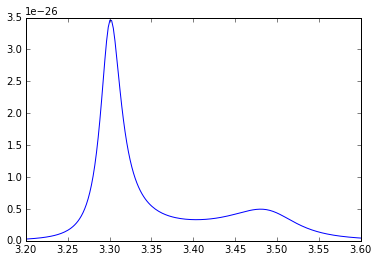

In [324]:
a = 7e-9
r1 = np.array([8e-9,0,0]) # atom position
ω_p = 9*eV/ℏ
#print(ω_p)
ε_inf = 4.6
γ_p = 0.1*eV/ℏ
ε_b = 1
γ_QE = 0.015*eV/ℏ
μ = np.array([0.19e-9*e,0,0])

R = np.array([0,8e-9,0]) # detector position
ω_0 = 3.3*eV/ℏ
Ω = ω_0+1j*γ_QE
startω = 3.2*eV/ℏ
stopω = 3.6*eV/ℏ
nmax=10

ωlist = np.linspace(startω, stopω, 200)
Slist = np.empty(shape=ωlist.shape,dtype=float)
for i in range(ωlist.shape[0]):
    ω = ωlist[i]
    ε_m = ε_drude(ε_inf, ω_p, γ_p, ω)
    #print ("ε_m",ε_m)
    G = mie_G_scatt(a=a, nmax=nmax, ε_m=ε_m,
                    ε_b=ε_b, ω=ω, r1=r1, r2=R)
    pref = np.linalg.norm((ω*ω/(c*c*ε_0))*np.dot(G, μ))**2
    postf = 1/abs(ω-Ω)**2+1/abs(ω+Ω)**2
    Slist[i] = pref*postf
plt.plot(ωlist*ℏ/eV,Slist)
    

# Playground

In [201]:
n = np.arange(6)
n[:,nx] * n[nx,:]

array([[ 0,  0,  0,  0,  0,  0],
       [ 0,  1,  2,  3,  4,  5],
       [ 0,  2,  4,  6,  8, 10],
       [ 0,  3,  6,  9, 12, 15],
       [ 0,  4,  8, 12, 16, 20],
       [ 0,  5, 10, 15, 20, 25]])

In [19]:
r = np.array([[1,0,0],[2,2,2]])
R = np.array([[0,1,0],[0,1,4]])
np.linalg.norm((r-R), axis=1)
G_fs(r, R, 2e8)

array([[ 0.03302973+0.04555572j,  0.00000000+0.j        ,
         0.00000000+0.j        ,  0.00000000+0.j        ,
         0.03302973+0.04555572j,  0.00000000+0.j        ,
         0.00000000+0.j        ,  0.00000000+0.j        ,
         0.03302973+0.04555572j],
       [-0.01107202+0.02410456j, -0.00000000+0.j        ,
        -0.00000000+0.j        , -0.00000000+0.j        ,
        -0.01107202+0.02410456j, -0.00000000+0.j        ,
        -0.00000000+0.j        , -0.00000000+0.j        ,
        -0.01107202+0.02410456j]])

In [235]:
np.seterr(divide='raise')
#spherical_vector_waves(5, 1, np.array([0,0.0001,1]))


{'divide': 'raise', 'invalid': 'warn', 'over': 'warn', 'under': 'ignore'}

In [286]:
a=50e-9
nmax=5
ε_m=-3.3024390243902424+0.24695121951219506j
ε_b=1
ω=c/500e-9
(RH,RV)=mie_reflection_coefficients(a=a, nmax=nmax, ε_m=ε_m, ε_b=ε_b, ω=ω)
mie_G_scatt_precalcd(a=a, nmax=nmax, ε_b=ε_b, ω=ω, RH=RH, RV=RV, r1=np.array([60e-9,0,0]), r2=np.array([0,60e-9,0]))

(5e-08, 5, (-3.3024390243902424+0.24695121951219506j), 1, 599584916000000.0)


array([[ -2.32297859e+02 -3.17161350e+01j,
          1.20253598e-04 +9.53143048e-06j,
          0.00000000e+00 +0.00000000e+00j],
       [ -5.42281207e-04 +6.42401046e-06j,
         -2.32297859e+02 -3.17161350e+01j,
          0.00000000e+00 +0.00000000e+00j],
       [  0.00000000e+00 +0.00000000e+00j,
          0.00000000e+00 +0.00000000e+00j,
         -2.31963212e+02 -3.16704449e+01j]])

In [287]:
mie_G_scatt(a=a, nmax=nmax, ε_m=ε_m, ε_b=ε_b, ω=ω, r1=np.array([60e-9,0,0]), r2=np.array([0,60e-9,0]))
#(RH, RV) = mie_reflection_coefficients(a, nmax, ε_m, ε_b, ω)
#mie_G_scatt_precalcd(a, nmax, ε_b, ω, RH, RV, r1, r2)m

(5e-08, 5, (-3.3024390243902424+0.24695121951219506j), 1, 599584916000000.0)
[  8.13818602e-05 +1.40702053e-03j   5.43528767e-08 +9.50836700e-07j
   1.56022588e-11 +2.72347866e-10j   2.48098873e-15 +4.32728136e-14j
   2.50831510e-19 +4.37326736e-18j   1.75499704e-23 +3.05919479e-22j] [  1.77618510e-01 +3.53782431e-01j   3.00212315e-04 -2.19883911e-03j
   6.25115443e-08 -7.88678899e-07j   1.24040855e-11 -1.83448648e-10j
   1.63867255e-15 -2.62046092e-14j   1.48111664e-19 -2.48158929e-18j]


array([[ -2.32297859e+02 -3.17161350e+01j,
          1.20253598e-04 +9.53143048e-06j,
          0.00000000e+00 +0.00000000e+00j],
       [ -5.42281207e-04 +6.42401046e-06j,
         -2.32297859e+02 -3.17161350e+01j,
          0.00000000e+00 +0.00000000e+00j],
       [  0.00000000e+00 +0.00000000e+00j,
          0.00000000e+00 +0.00000000e+00j,
         -2.31963212e+02 -3.16704449e+01j]])

In [244]:
mie_G_scatt(a=a, nmax=nmax, ε_m=ε_m, ε_b=ε_b, ω=ω, r1=np.array([60e-9,0,0]), r2=np.array([60e-9,0,0]))


array([[-2.34147492-2.19632374j,  0.00000000+0.j        ,  0.00000000+0.j        ],
       [ 0.00000000+0.j        , -2.33474100-2.1900078j ,  0.00000000+0.j        ],
       [ 0.00000000+0.j        ,  0.00000000+0.j        ,
        -2.33474100-2.1900078j ]])

In [246]:
mie_G_scatt(a=a, nmax=5*nmax, ε_m=ε_m, ε_b=ε_b, ω=ω, r1=np.array([60e-9,0,0]), r2=np.array([0,60e-9,0]))


array([[ -2.33809776e+00 -2.19315598e+00j,
          2.02411316e-06 +1.87437796e-06j,
          0.00000000e+00 +0.00000000e+00j],
       [  5.41975756e-06 +5.64566844e-06j,
         -2.33809776e+00 -2.19315598e+00j,
          0.00000000e+00 +0.00000000e+00j],
       [  0.00000000e+00 +0.00000000e+00j,
          0.00000000e+00 +0.00000000e+00j,
         -2.33472952e+00 -2.18999654e+00j]])

In [251]:
abs(2j+1)

2.23606797749979

In [254]:
np.linalg.norm(np.array([1,1j,0]))

1.4142135623730951